In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.impute import KNNImputer
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import seaborn as sns

# 1. HMM

Read data from training on WM grid:

In [2]:
data = pd.read_csv('data/final_data_cogmed_max_25min.csv', index_col=0)  # final_data_cogmed_max_25min.csv
accounts = data.treatmentid.unique()
data

,treatmentid,treatmentday,triallevel
5864846,208909,0.0,6.40
5864851,208909,1.0,5.85
5864856,208909,2.0,5.70
5864859,208909,3.0,6.00
5864864,208909,4.0,5.85
...,...,...,...
7949153,254388,12.0,7.70
7949159,254388,14.0,7.70
7949166,254388,16.0,6.95
7949173,254388,18.0,7.45


### Functions for HMM optimization of the funcion

In [20]:
def calc_prob_list(tau, N, normal_dist): 
    """
    Calculate the probablity for each possible transition day. The function returns a list of probabilities p_list 
    where p_list[n] is the probability that the transition from phase 1 to phase 2 happens between day n and day n+1. 
    """
    p_list = np.zeros(N)   
    for k in range(N-1):
        p_list[k] = (1 - tau[0])**k * tau[0] * normal_dist[0, k] * normal_dist[1, k+1]
    p_list[N-1] = (1 - tau[0])**(N-1) * normal_dist[0, N-1]   
    return p_list

            
def calc_normal1(times, levels, a, b, sigma):
    """
    Calculate the probablity of the observed training data point given that it is part of phase 1 (i.e. that the data 
    point is observed before the transission day). 
    """
    p = (1/(sigma*np.sqrt(2*np.pi))) *np.exp(-0.5*( (levels - (b*times + a)) / sigma )**2 )
    p = np.cumprod(p)
    return p


def calc_normal2(times, levels, a, b, sigma):
    """
    Calculate the probablity of the observed training data point given that it is part of phase 2 (i.e. that the data 
    point is observed after the transission day). 
    """
    p = (1/(sigma*np.sqrt(2*np.pi))) *np.exp(-0.5*( (levels - (b*times + a)) / sigma )**2 )
    p = np.flip(np.cumprod(np.flip(p)))
    return p


def e_step(prob_list, w1, w2): 
    """
    w1 calculates the probability of a given day being in phase 1 and w2 calculated the probability of a given day 
    being in phase 2. This is the expecation step of the EM algorithm. 
    """
    w2[1:] = np.cumsum(prob_list)
    w1 = 1 - w2
    return w1, w2

def f(var, x, y, w1, w2, p_norm): 
    """
    The definition of the function to be maximized in the maximization step. It consists of three parts: (1) one 
    ML estimate weighted using the probabilties of being in phase 1, (2) one ML estimate weighted using the 
    probabilties of being in phase 2 and (3) the probability of day n being in a specific phase given the phases of
    previous days. 
    """
    N = y.shape[0]
    val = (0.5/0.49) * np.sum(w1 * (y - var[0] - var[1]*x - var[2]*x)**2 ) 
    val = val + (0.5/0.49) * np.sum(w2 * (y - var[0] - var[2]*x - (var[1]/var[3]))**2 ) 
    val = val - np.sum(w1[1:])*np.log(1 - var[3]) 
    val = val - np.sum(p_norm[:N-1])*np.log(var[3])
    return val

def m_step(x, y, w1, w2, p_norm, a, b, tau):
    """
    The function maximized the probability of the observed data and the most probable phase for each day given the
    parameter values, with respect to the parameter vales. 
    """
    x0 = [a, b[0], b[1], tau]
    con1 = {'type': 'ineq', 'fun': constraint1}
    con2 = {'type': 'ineq', 'fun': constraint2}
    con3 = {'type': 'ineq', 'fun': constraint3}
    return minimize(f, x0, args=(x, y, w1, w2, p_norm), constraints=[con1, con2, con3], tol=1e-10)

def constraint1(var):
    """ 
    Constrains the probability of transition from phase 1 - 2 such that the expected value is 8 days maximum. 
    """
    return var[3] - 0.125

def constraint2(var):
    """ 
    Constrains the probability of transition from phase 1 - 2 such that it cannot be higher that 0.99. 
    """
    return 0.99 - var[3]

def constraint3(var):
    """ 
    Constrains the slope of the strategy improvement to positive values. 
    """
    return var[1]


### 1.1 Run the HMM optimization above

In [21]:
def run_alg(time, level):
    
    # initialization of paramters
    a = 5 
    b = np.array([0.6, 0.06])  
    tau = np.array([0.5, 0])
    sigma = 0.7
    N = level.shape[0]
    w1 = np.zeros(N)
    w2 = np.zeros(N)
    print_probs = []

    for i in range(40):
        # calculate probabilities
        p0 = calc_normal1(time, level, a, b[0] + b[1], sigma)
        p1 = calc_normal2(time, level, a + b[0]*(1/tau[0]), b[1], sigma)
        p = np.array([p0, p1]) 
        prob_list = calc_prob_list(tau, N, p)
        prob_norm = prob_list/np.sum(prob_list)
        
        # expectation step
        w1, w2 = e_step(prob_norm[:N-1], w1, w2)
        
        # maximization step
        res = m_step(time, level, w1, w2, prob_norm, a, b, tau[0])
        a = res.x[0]
        b = [res.x[1], res.x[2]]
        tau[0] = res.x[3]
        
        # Save the probabilty given the current parameter values to make sure that the probability doesn't decrease. 
        # That would indicate an error on the algorithm. 
        print_probs.append(np.sum(prob_list))
        
    return print_probs, w1, w2, a, b, tau[0]

### Plot an example of an optimized curve

In [22]:
def plot_result(w1, w2, a, b, time, level, t_switch, i):
    time1 = time[np.where(time < t_switch)[0]]
    time2 = time[np.where(time > t_switch)[0]]
    time1 = np.insert(time1, time1.shape[0], t_switch, axis=0)
    time2 = np.insert(time2, 0, t_switch, axis=0) 
    
    ax = plt.subplot(1, 2, i)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=18)

    plt.plot(time1, a + b[0]*time1 + b[1]*time1, color="#d3494e", linewidth=3) 
    plt.plot(time2, a + b[0]*t_switch + b[1]*time2, color="#d3494e", linewidth=3)
    plt.scatter(time, level, facecolors='none', edgecolors="#3F5D7D", alpha=1, marker='o', linewidths=3)  
    plt.xlabel('Training day', fontsize=20)
    plt.ylabel('Level', fontsize=20)
    
    plt.plot([t_switch, t_switch], [a + b[0]*t_switch + b[1]*t_switch, ax.get_ylim()[0]], color="#d3494e", linestyle='--', alpha=0.5, linewidth=3)
    plt.ylim(ax.get_ylim()[0] + 0.15, ax.get_ylim()[1])
    plt.xlim(0, 38)
    

6.896415436972553 [0.2843263154457026, 0.028446985249098316] 3.972092918489812


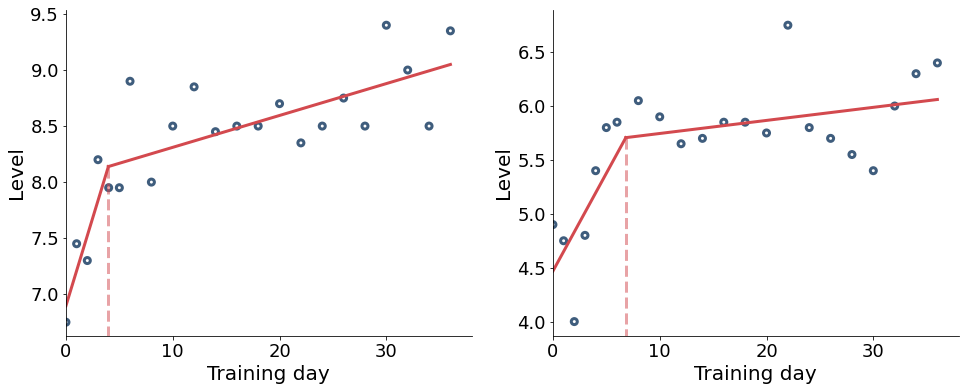

4.468771253535313 [0.16927185260893898, 0.012132738938347133] 6.824370845024159


In [23]:
plt.figure(figsize=(16, 6)) 

user = 16 # 5, 18, 115, 121    16
response = data[data.treatmentid == accounts[user]]
time = response.treatmentday.values
level = response.triallevel.values
print_probs, w1, w2, a, b, tau = run_alg(time, level)
plot_result(w1, w2, a, b, time, level, 1/tau, 1)

print(a, b, 1/tau)

user = 5 # 5, 18, 115, 121    16
response = data[data.treatmentid == accounts[user]]
time = response.treatmentday.values
level = response.triallevel.values
print_probs, w1, w2, a, b, tau = run_alg(time, level)
plot_result(w1, w2, a, b, time, level, 1/tau, 2)
plt.show()

print(a, b, 1/tau)

# PLOT PROBABILITY TO MAKE SURE IT DOESN*T DECREASE
#plt.plot(range(len(print_probs)), print_probs, color='darkslateblue')
#plt.xlabel('iteration', fontsize=14)
#plt.ylabel('likelihood', fontsize=14)
#plt.show()

### 1.2 Calculate values for whole population

Apart from the final parameter values, the covariance matrix for the levels on each day as well as AIC values are also saved.

In [24]:
nr_subjects = accounts.shape[0]
slope1 = np.zeros(nr_subjects)
slope2 = np.zeros(nr_subjects)
intercept = np.zeros(nr_subjects)
taus = np.zeros(nr_subjects)
aics = np.zeros(nr_subjects)
sigma1 = 0
sigma2 = 0
count1 = 0
count2 = 0
covariance_mat = np.zeros((22, 22))
count3 = 0

for user in range(nr_subjects):
    response = data[data.treatmentid == accounts[user]]
    time = response.treatmentday.values
    level = response.triallevel.values
    print_probs, w1, w2, a, b, tau = run_alg(time, level)
    if print_probs[-1] > 0:
        slope1[user] = b[0]
        slope2[user] = b[1]
        intercept[user] = a
        taus[user] = tau

        t_switch = (1/tau).astype(int)
        if t_switch > 2:
            count1 += 1
            sigma1 += np.sum((level[:t_switch] - time[:t_switch]*(b[0] + b[1]) - a)**2) / (t_switch-2)
        left = len(time[t_switch:])
        if left > 2:
            sigma2 += np.sum((level[t_switch:] - time[t_switch:]*b[1] - (1/tau)*b[0] - a)**2) / (time[t_switch:].shape[0]-2)
            count2 += 1
        if time.shape[0] == 22:
            e = np.zeros((22, 1))
            e[:t_switch, 0] = level[:t_switch] - time[:t_switch]*(b[0] + b[1]) - a
            e[t_switch:, 0] = level[t_switch:] - time[t_switch:]*b[1] - (1/tau)*b[0] - a
            count3 += 1
            covariance_mat += np.dot(e, e.T)
        # bic = 4*np.log(level.shape[0]) - 2*np.log(np.sum(print_probs[-1]))
        aic = 2*4 - 2*np.log(np.sum(print_probs[-1]))
        aics[user] = aic
print(np.mean(taus[~np.isnan(taus)]))

/var/folders/tr/b56f8fy53yl838fmsqxvnsm00000gq/T/ipykernel_35705/4005135617.py:18: RuntimeWarning: invalid value encountered in true_divide
  prob_norm = prob_list/np.sum(prob_list)


0.5326850382176893


Remove data for subjects where the probabilities were numerically too small for the EM algorithm:

In [25]:
idx = np.where(intercept != 0)[0]
slope1 = slope1[idx]
slope2 = slope2[idx]
intercept = intercept[idx]
taus = taus[idx]
aics = aics[idx]
print(accounts.shape[0] - idx.shape[0])

Create and save covariance matrix

In [138]:
cov = pd.DataFrame(np.around(covariance_mat/(count3-2), decimals=2))
cov.to_excel('cov_matrix.xlsx')

### 1.3 Results from the averaged parameter values compared with average performance
In this graph the results from the Tanh function are also included. 

In [79]:
data_grouped = data.drop(columns=['treatmentid']).groupby('treatmentday').agg(trial_level_median=('triallevel', 'median'), trial_level_std=('triallevel', 'std')).reset_index()
data_grouped = data_grouped[data_grouped.treatmentday < 38.0]

0.32271638933062496
0.011630798111820124
1.9161737556704086
5.4002611198439245


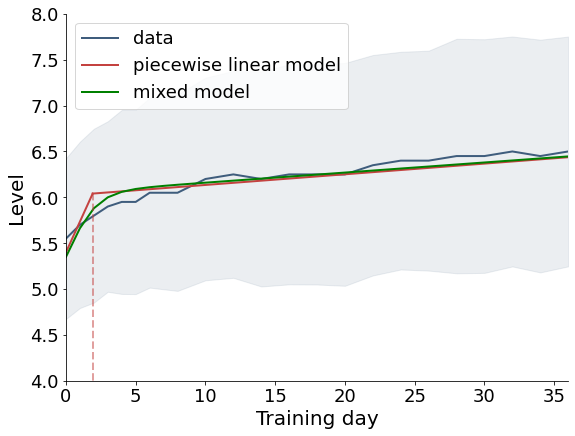

In [86]:
plt.figure(figsize=(9, 6.75)) 

tau_mean = np.nanmedian(taus) 
a1 = np.nanmedian(intercept) 
b1 = np.nanmean(slope1)
b2 = np.nanmedian(slope2)
print(b1)
print(b2)
print(1/tau_mean)
print(a1)
t_switch = 1/tau_mean
time = np.linspace(0, 36, 37)
time1 = time[np.where(time < t_switch)[0]]
time2 = time[np.where(time > t_switch)[0]]
time1 = np.insert(time1, time1.shape[0], t_switch, axis=0)
time2 = np.insert(time2, 0, t_switch, axis=0) 

ax = plt.subplot(1, 1, 1)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.plot(data_grouped.treatmentday, data_grouped.trial_level_median, color="#3F5D7D", label='data', linewidth=2)
plt.fill_between(data_grouped.treatmentday, data_grouped.trial_level_median - data_grouped.trial_level_std, data_grouped.trial_level_median + data_grouped.trial_level_std, color="#3F5D7D", alpha=.1)

plt.plot(time1, a1 + b1*time1 + b2*time1, color="#c44240", label='piecewise linear model', linewidth=2)
plt.plot(time2, a1 + b1*t_switch + b2*time2, color="#c44240", linewidth=2)
plt.plot(time, 5.35 + time*0.011 + 0.70*np.tanh(0.461*time), color="green", label='mixed model', linewidth=2)

plt.plot([1.92, 1.92], [6.05, 0], color="#c44240", linestyle='--', alpha=0.5, linewidth=2)

plt.xlabel('Training day', fontsize=20)
plt.ylabel('Level', fontsize=20)

plt.xlim((0, 36))
plt.ylim(4, 8)
plt.legend(loc='upper left', fontsize=18)

plt.show()

### 1.4 Save results

In [143]:
slope1 = slope1/taus

In [144]:
accounts = accounts[idx]

In [156]:
results_df = pd.DataFrame(index=accounts, data={'intercept': intercept, 'slope1': slope1, 'slope2': slope2, 'day': 1/taus})
results_df.to_csv('data/HMM_slopes_linear2.csv')

# 2. HMM and CFA comparision

### 2.1 Create dataframe including both HMM values and CFA values

In [46]:
results_df = pd.read_csv('data/HMM_slopes_linear2.csv', index_col=0)
results_df

,intercept,slope1,slope2,day
208909,6.029617,4.411987e-17,0.011534,1.695986
208996,5.618768,3.694915e-01,-0.004870,2.618726
209052,3.995350,1.349046e+00,0.000149,3.105450
209183,4.737537,1.117039e+00,-0.019565,8.000000
209193,5.955139,1.518804e-01,0.004979,1.243892
...,...,...,...,...
253783,5.651819,8.288698e-01,0.045311,2.236954
253920,4.439748,1.134848e+00,-0.060944,4.774215
254361,5.350036,9.392938e-01,0.075536,1.013700
254379,6.425994,4.086556e-01,0.007354,1.855574


In [47]:
test_data = pd.read_csv('fscores_cogmed_25_9to11_2factors.csv', index_col=0)  
test_data_info = pd.read_csv('data/test_data_max_long_25min.csv', index_col=0)
test_data.index = test_data_info.index
test_data

,factor2,factor3,factor4,factor5,factor6,factor22,factor32,factor42,factor52,factor62
208909,-0.212121,-0.386241,-0.210690,-0.044718,0.360330,1.221812,0.209600,1.309062,0.884245,0.949346
208996,-0.094633,0.122923,0.435866,0.523262,0.910307,0.363719,0.399203,0.566038,-0.121153,-0.778365
209052,-0.850632,-0.834953,-0.630472,-0.512722,-0.100993,-0.810493,0.149304,0.548539,-0.133013,0.237918
209183,-1.294203,-1.239499,-1.074591,-1.044818,-0.801206,0.008906,0.849707,0.926505,1.727955,-2.911312
209193,-0.010703,-0.073705,0.139322,0.418003,0.753296,0.533519,0.789161,1.063859,0.874632,0.640979
...,...,...,...,...,...,...,...,...,...,...
253070,0.389844,0.642759,0.938837,1.127696,1.414540,0.160288,1.051754,0.436467,-0.094683,0.534497
253192,-0.600162,-0.302827,0.076166,0.209832,0.526016,-0.123313,0.733295,1.172334,0.006970,0.097029
253232,0.015788,0.182473,0.322952,0.306174,0.749014,0.041409,1.501320,-1.377933,0.019742,-0.533965
253503,0.013999,0.272608,0.605413,0.810424,1.089877,0.101728,0.723607,0.462449,0.831811,0.276703


This creates one measure for strategy

In [48]:
test_data['diff_strat'] = test_data['factor32'] - test_data['factor22']
test_data = test_data.drop(columns = ['factor22', 'factor32'])
test_data

,factor2,factor3,factor4,factor5,factor6,factor42,factor52,factor62,diff_strat
208909,-0.212121,-0.386241,-0.210690,-0.044718,0.360330,1.309062,0.884245,0.949346,-1.012212
208996,-0.094633,0.122923,0.435866,0.523262,0.910307,0.566038,-0.121153,-0.778365,0.035484
209052,-0.850632,-0.834953,-0.630472,-0.512722,-0.100993,0.548539,-0.133013,0.237918,0.959798
209183,-1.294203,-1.239499,-1.074591,-1.044818,-0.801206,0.926505,1.727955,-2.911312,0.840801
209193,-0.010703,-0.073705,0.139322,0.418003,0.753296,1.063859,0.874632,0.640979,0.255642
...,...,...,...,...,...,...,...,...,...
253070,0.389844,0.642759,0.938837,1.127696,1.414540,0.436467,-0.094683,0.534497,0.891466
253192,-0.600162,-0.302827,0.076166,0.209832,0.526016,1.172334,0.006970,0.097029,0.856608
253232,0.015788,0.182473,0.322952,0.306174,0.749014,-1.377933,0.019742,-0.533965,1.459911
253503,0.013999,0.272608,0.605413,0.810424,1.089877,0.462449,0.831811,0.276703,0.621879


The capacity slope is calculated using linear regression. 

In [49]:
slopes = []
times = [2, 10, 20, 30, 40]
r = []
for user in test_data.index:
    response = test_data.loc[user]
    response = response[['factor2', 'factor3', 'factor4', 'factor5', 'factor6']]
    res = linregress(times, response.values)
    slopes.append(res.slope)
    r.append(res.rvalue**2)
test_data['diff_wm'] = slopes
test_data = test_data[['diff_strat', 'diff_wm']] 

In [50]:
np.mean(r)

0.8807509047610317

In [51]:
results_df = results_df.join(test_data)

In [52]:
results_df = results_df.dropna()
results_df

,intercept,slope1,slope2,day,diff_strat,diff_wm
208909,6.029617,4.411987e-17,0.011534,1.695986,-1.012212,0.015855
208996,5.618768,3.694915e-01,-0.004870,2.618726,0.035484,0.025080
209052,3.995350,1.349046e+00,0.000149,3.105450,0.959798,0.019157
209183,4.737537,1.117039e+00,-0.019565,8.000000,0.840801,0.012348
209193,5.955139,1.518804e-01,0.004979,1.243892,0.255642,0.021323
...,...,...,...,...,...,...
253070,5.900705,7.231962e-01,-0.002687,1.041228,0.891466,0.026340
253192,5.047745,9.280042e-01,0.004099,7.095556,0.856608,0.028690
253232,5.734086,8.089278e-01,-0.030436,4.364799,1.459911,0.016576
253503,5.600567,3.759059e-01,0.031288,1.028804,0.621879,0.027954


### 2.2 Vizualise distributions

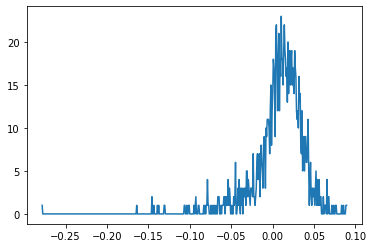

In [87]:
hist = np.histogram(results_df.slope2, bins=500)  # results_df.slope1
plt.plot(hist[1][1:], hist[0][:])
plt.show()

/Users/julia.ericson/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


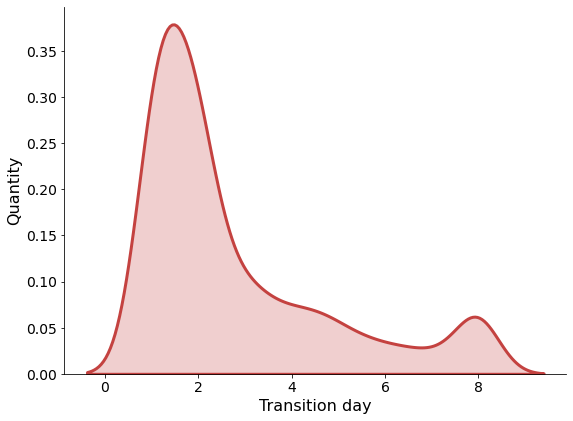

0.02063324515848821


In [89]:
plt.figure(figsize=(9, 6.75)) 
ax = plt.subplot(1, 1, 1)  

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)

sns.distplot(1/taus, hist=False, kde=True, bins=int(180/5), color="#c44240", 
             hist_kws={'edgecolor':'black'}, kde_kws={'shade': True,'linewidth': 3})

plt.xlabel('Transition day', fontsize=16)
plt.ylabel('Quantity', fontsize=16)

plt.show()
print(np.median(results_df.diff_wm*0.77))

In [88]:
np.median(results_df.day)

1.9032543356089984

### 1.3 Look at correlation

In [53]:
correlations = results_df.corr()
correlations

,intercept,slope1,slope2,day,diff_strat,diff_wm
intercept,1.000000,-0.249069,0.055624,0.017256,-0.250071,0.300853
slope1,-0.249069,1.000000,-0.281716,0.362859,0.726080,0.221450
slope2,0.055624,-0.281716,1.000000,-0.176220,0.022550,0.527499
day,0.017256,0.362859,-0.176220,1.000000,0.146884,0.049880
diff_strat,-0.250071,0.726080,0.022550,0.146884,1.000000,0.205659
diff_wm,0.300853,0.221450,0.527499,0.049880,0.205659,1.000000
